# Triplet Loss for Implicit Feedback Neural Recommender Systems

The goal of this notebook is first to demonstrate how it is possible to build a bi-linear recommender system only using positive feedback data.

In a latter section we show that it is possible to train deeper architectures following the same design principles.

This notebook is inspired by Maciej Kula's [Recommendations in Keras using triplet loss](
https://github.com/maciejkula/triplet_recommendations_keras). Contrary to Maciej we won't use the BPR loss but instead will introduce the more common margin-based comparator.

## Loading the movielens-100k dataset

For the sake of computation time, we will only use the smallest variant of the movielens reviews dataset. Beware that the architectural choices and hyperparameters that work well on such a toy dataset will not necessarily be representative of the behavior when run on a more realistic dataset such as [Movielens 10M](https://grouplens.org/datasets/movielens/10m/) or the [Yahoo Songs dataset with 700M rating](https://webscope.sandbox.yahoo.com/catalog.php?datatype=r).

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os.path as op

from zipfile import ZipFile
try:
    from urllib.request import urlretrieve
except ImportError:  # Python 2 compat
    from urllib import urlretrieve


ML_100K_URL = "http://files.grouplens.org/datasets/movielens/ml-100k.zip"
ML_100K_FILENAME = ML_100K_URL.rsplit('/', 1)[1]
ML_100K_FOLDER = 'ml-100k'

if not op.exists(ML_100K_FILENAME):
    print('Downloading %s to %s...' % (ML_100K_URL, ML_100K_FILENAME))
    urlretrieve(ML_100K_URL, ML_100K_FILENAME)

if not op.exists(ML_100K_FOLDER):
    print('Extracting %s to %s...' % (ML_100K_FILENAME, ML_100K_FOLDER))
    ZipFile(ML_100K_FILENAME).extractall('.')

In [2]:
data_train = pd.read_csv(op.join(ML_100K_FOLDER, 'ua.base'), sep='\t',
                        names=["user_id", "item_id", "rating", "timestamp"])
data_test = pd.read_csv(op.join(ML_100K_FOLDER, 'ua.test'), sep='\t',
                        names=["user_id", "item_id", "rating", "timestamp"])

data_train.describe()

,user_id,item_id,rating,timestamp
count,90570.000000,90570.000000,90570.000000,9.057000e+04
mean,461.494038,428.104891,3.523827,8.835073e+08
std,266.004364,333.088029,1.126073,5.341684e+06
min,1.000000,1.000000,1.000000,8.747247e+08
25%,256.000000,174.000000,3.000000,8.794484e+08
50%,442.000000,324.000000,4.000000,8.828143e+08
75%,682.000000,636.000000,4.000000,8.882049e+08
max,943.000000,1682.000000,5.000000,8.932866e+08


In [3]:
def extract_year(release_date):
    if hasattr(release_date, 'split'):
        components = release_date.split('-')
        if len(components) == 3:
            return int(components[2])
    # Missing value marker
    return 1920


m_cols = ['item_id', 'title', 'release_date', 'video_release_date', 'imdb_url']
items = pd.read_csv(op.join(ML_100K_FOLDER, 'u.item'), sep='|',
                    names=m_cols, usecols=range(5), encoding='latin-1')
items['release_year'] = items['release_date'].map(extract_year)

data_train = pd.merge(data_train, items)
data_test = pd.merge(data_test, items)

In [4]:
data_train.head()

,user_id,item_id,rating,timestamp,title,release_date,video_release_date,imdb_url,release_year
0,1,1,5,874965758,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,1995
1,2,1,4,888550871,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,1995
2,6,1,4,883599478,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,1995
3,10,1,4,877888877,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,1995
4,13,1,3,882140487,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,1995


In [5]:
# data_test.describe()

In [6]:
max_user_id = max(data_train['user_id'].max(), data_test['user_id'].max())
max_item_id = max(data_train['item_id'].max(), data_test['item_id'].max())

n_users = max_user_id + 1
n_items = max_item_id + 1

print('n_users=%d, n_items=%d' % (n_users, n_items))

n_users=944, n_items=1683


## Implicit feedback data

Consider ratings >= 4 as positive feed back and ignore the rest:

In [7]:
pos_data_train = data_train.query("rating >= 4")
pos_data_test = data_test.query("rating >= 4")

Because the median rating is around 3.5, this cut will remove approximately half of the ratings from the datasets:

In [8]:
pos_data_train['rating'].count()

49906

In [9]:
pos_data_test['rating'].count()

5469

## The Triplet Loss

The following section demonstrates how to build a low-rank quadratic interaction model between users and items. The similarity score between a user and an item is defined by the unormalized dot products of their respective embeddings.

The matching scores can be use to rank items to recommend to a specific user.

Training of the model parameters is achieved by randomly sampling negative items not seen by a pre-selected anchor user. We want the model embedding matrices to be such that the similarity between the user vector and the negative vector is smaller than the similarity between the user vector and the positive item vector. Furthermore we use a margin to further move appart the negative from the anchor user.

Here is the architecture of such a triplet architecture. The triplet name comes from the fact that the loss to optimize is defined for triple `(anchor_user, positive_item, negative_item)`:

<img src="frame1.png" style="width: 600px;" />

We call this model a triplet model with bi-linear interactions because the similarity between a user and an item is captured by a dot product of the first level embedding vectors. This is therefore not a deep architecture.

In [10]:
import tensorflow as tf
from tensorflow.keras import layers


def identity_loss(y_true, y_pred):
    """Ignore y_true and return the mean of y_pred
    
    This is a hack to work-around the design of the Keras API that is
    not really suited to train networks with a triplet loss by default.
    """
    return tf.reduce_mean(y_pred)


class MarginLoss(layers.Layer):

    def __init__(self, margin=1.):
        super().__init__()
        self.margin = margin
        
    def call(self, inputs):
        pos_pair_similarity = inputs[0]
        neg_pair_similarity = inputs[1]
        
        diff = neg_pair_similarity - pos_pair_similarity
        return tf.maximum(diff + self.margin, 0.)

Here is the actual code that builds the model(s) with shared weights. Note that here we use the cosine similarity instead of unormalized dot products (both seems to yield comparable results).

The triplet model is used to train the weights of the companion
similarity model. The triplet model takes 1 user, 1 positive item
(relative to the selected user) and one negative item and is
trained with comparator loss.

The similarity model takes one user and one item as input and return
compatibility score (aka the match score).

In [48]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Embedding, Flatten, Input, Dense
from tensorflow.keras.layers import Lambda, Dot
from tensorflow.keras.regularizers import l2


class TripletModel(Model):
    def __init__(self, n_users, n_items, latent_dim=64,
                 l2_reg=None, margin=1.):
        super().__init__(name="TripletModel")
        
        self.margin = margin
        
        l2_reg = None if l2_reg == 0 else l2(l2_reg)

        self.user_layer = Embedding(n_users, latent_dim,
                                    input_length=1,
                                    input_shape=(1,),
                                    name='user_embedding',
                                    embeddings_regularizer=l2_reg)
    
        # The following embedding parameters will be shared to
        # encode both the positive and negative items.
        self.item_layer = Embedding(n_items, latent_dim,
                                    input_length=1,
                                    name="item_embedding",
                                    embeddings_regularizer=l2_reg)
        
        # The 2 following layers are without parameters, and can
        # therefore be used for both positive and negative items.
        self.flatten = Flatten()
        self.dot = Dot(axes=1, normalize=True)

        self.margin_loss = MarginLoss(margin)
        
    def call(self, inputs, training=False):
        user_input = inputs[0]
        pos_item_input = inputs[1]
        neg_item_input = inputs[2]
        
        user_embedding = self.user_layer(user_input)
        user_embedding = self.flatten(user_embedding)
        
        pos_item_embedding = self.item_layer(pos_item_input)
        pos_item_embedding = self.flatten(pos_item_embedding)
        
        neg_item_embedding = self.item_layer(neg_item_input)
        neg_item_embedding = self.flatten(neg_item_embedding)
        
        # Similarity computation between embeddings
        pos_similarity = self.dot([user_embedding, pos_item_embedding])
        neg_similarity = self.dot([user_embedding, neg_item_embedding])
                
        return self.margin_loss([pos_similarity, neg_similarity])
    
    def model(self):
        x = Input(shape=(1,))
        y = Input(shape=(1,))
        z = Input(shape=(1,))
        return Model(inputs=[x, y, z], outputs=self.call([x, y, z]))
    

triplet_model = TripletModel(n_users, n_items,
                             latent_dim=64, l2_reg=1e-6)

In [49]:
triplet_model.model().summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_5 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 user_embedding (Embedding)     (None, 1, 64)        60416       ['input_4[0][0]']                
                                                                                            

In [12]:
class MatchModel(Model):

    def __init__(self, user_layer, item_layer):
        super().__init__(name="MatchModel")
        
        # Reuse shared weights for those layers:
        self.user_layer = user_layer
        self.item_layer = item_layer
        
        self.flatten = Flatten()
        self.dot = Dot(axes=1, normalize=True)
    
    def call(self, inputs):
        user_input = inputs[0]
        pos_item_input = inputs[1]
        
        user_embedding = self.user_layer(user_input)
        user_embedding = self.flatten(user_embedding)

        pos_item_embedding = self.item_layer(pos_item_input)
        pos_item_embedding = self.flatten(pos_item_embedding)
    
        pos_similarity = self.dot([user_embedding,
                                   pos_item_embedding])
        
        return pos_similarity
    

match_model = MatchModel(triplet_model.user_layer,
                         triplet_model.item_layer)

Note that `triplet_model` and `match_model` have as much parameters, they share both user and item embeddings. Their only difference is that the latter doesn't compute the negative similarity.

## Quality of Ranked Recommendations

Now that we have a randomly initialized model we can start computing random recommendations. To assess their quality we do the following for each user:

- compute matching scores for items (except the movies that the user has already seen in the training set),
- compare to the positive feedback actually collected on the test set using the ROC AUC ranking metric,
- average ROC AUC scores across users to get the average performance of the recommender model on the test set.

In [13]:
from sklearn.metrics import roc_auc_score


def average_roc_auc(model, data_train, data_test):
    """Compute the ROC AUC for each user and average over users"""
    max_user_id = max(data_train['user_id'].max(),
                      data_test['user_id'].max())
    max_item_id = max(data_train['item_id'].max(),
                      data_test['item_id'].max())
    user_auc_scores = []
    for user_id in range(1, max_user_id + 1):
        pos_item_train = data_train[data_train['user_id'] == user_id]
        pos_item_test = data_test[data_test['user_id'] == user_id]
        
        # Consider all the items already seen in the training set
        all_item_ids = np.arange(1, max_item_id + 1)
        items_to_rank = np.setdiff1d(
            all_item_ids, pos_item_train['item_id'].values)
        
        # Ground truth: return 1 for each item positively present in
        # the test set and 0 otherwise.
        expected = np.in1d(
            items_to_rank, pos_item_test['item_id'].values)
        
        if np.sum(expected) >= 1:
            # At least one positive test value to rank
            repeated_user_id = np.empty_like(items_to_rank)
            repeated_user_id.fill(user_id)

            predicted = model.predict(
                [repeated_user_id, items_to_rank], batch_size=4096)
        
            user_auc_scores.append(roc_auc_score(expected, predicted))

    return sum(user_auc_scores) / len(user_auc_scores)

By default the model should make predictions that rank the items in random order. The **ROC AUC score** is a ranking score that represents the **expected value of correctly ordering uniformly sampled pairs of recommendations**.

A random (untrained) model should yield 0.50 ROC AUC on average. 

In [14]:
average_roc_auc(match_model, pos_data_train, pos_data_test)

1/1 [==============================] - 0s 15ms/step


0.5059706523364277

## Training the Triplet Model

Let's now fit the parameters of the model by sampling triplets: for each user, select a movie in the positive feedback set of that user and randomly sample another movie to serve as negative item.

Note that this sampling scheme could be improved by removing items that are marked as positive in the data to remove some label noise. In practice this does not seem to be a problem though.

In [44]:
def sample_triplets(pos_data, max_item_id, random_seed=0):
    """Sample negatives at random"""
    rng = np.random.RandomState(random_seed)
    user_ids = pos_data['user_id'].values
    pos_item_ids = pos_data['item_id'].values

    neg_item_ids = rng.randint(low=1, high=max_item_id + 1,
                               size=len(user_ids))

    return [user_ids, pos_item_ids, neg_item_ids]

Let's train the triplet model:

In [45]:
from keras.callbacks import History 
history = History()

In [46]:
# we plug the identity loss and the a fake target variable ignored by
# the model to be able to use the Keras API to train the triplet model
fake_y = np.ones_like(pos_data_train["user_id"])
triplet_model = TripletModel(n_users, n_items,
                             latent_dim=64, l2_reg=1e-6)
triplet_model.compile(loss=identity_loss, optimizer="adam")

n_epochs = 10
batch_size = 64

for i in range(n_epochs):
    # Sample new negatives to build different triplets at each epoch
    triplet_inputs = sample_triplets(pos_data_train, max_item_id,
                                     random_seed=i)

    # Fit the model incrementally by doing a single pass over the
    # sampled triplets.
    triplet_model.fit(x=triplet_inputs, y=fake_y, shuffle=True,
                      batch_size=64, epochs=1, callbacks=[history])


# Evaluate the convergence of the model. Ideally we should prepare a
# validation set and compute this at each epoch but this is too slow.
test_auc = average_roc_auc(match_model, pos_data_train, pos_data_test)
print("Epoch %d/%d: test ROC AUC: %0.4f"
      % (i + 1, n_epochs, test_auc))

1/1 [==============================] - 0s 12ms/step
Epoch 10/10: test ROC AUC: 0.9270


In [19]:
a, b, c = triplet_inputs

triplet_model.fit(x=triplet_inputs, y=fake_y, shuffle=True,
                      batch_size=64, epochs=1, callbacks=[history])

780/780 [==============================] - 1s 939us/step - loss: 0.3005


In [47]:
a[2]
triplet_model.model().summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 tf.__operators__.getitem (Slic  (1,)                0           ['input_1[0][0]']                
 ingOpLambda)                                                                                     
                                                                                                  
 tf.__operators__.getitem_1 (Sl  (1,)                0           ['input_1[0][0]']                
 icingOpLambda)                                                                                   
                                                                                              

In [64]:

a[1], b[1], c[1]


(2, 1, 1060)

In [56]:
triplet_model.predict(np.array([a[1], b[1], c[1]])).mean(), triplet_model.predict(np.array([a[1], b[1], c[1]])).shape

1/1 [==============================] - 0s 14ms/step


(1.265625, (64, 1))

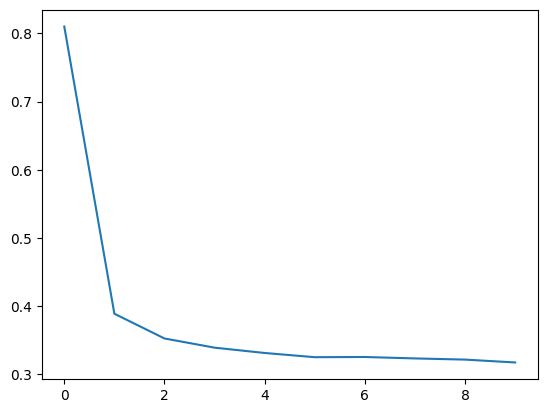

In [53]:
plt.plot(history.history['loss'])

### Exercise:

Count the number of parameters in `match_model` and `triplet_model`. Which model has the largest number of parameters?

In [17]:
print(match_model.summary())

Model: "MatchModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 user_embedding (Embedding)  multiple                  60416     
                                                                 
 item_embedding (Embedding)  multiple                  107712    
                                                                 
 flatten_1 (Flatten)         multiple                  0         
                                                                 
 dot_1 (Dot)                 multiple                  0         
                                                                 
Total params: 168,128
Trainable params: 168,128
Non-trainable params: 0
_________________________________________________________________
None


In [18]:
print(triplet_model.summary())

Model: "TripletModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 user_embedding (Embedding)  multiple                  60416     
                                                                 
 item_embedding (Embedding)  multiple                  107712    
                                                                 
 flatten (Flatten)           multiple                  0         
                                                                 
 dot (Dot)                   multiple                  0         
                                                                 
 margin_loss (MarginLoss)    multiple                  0         
                                                                 
Total params: 168,128
Trainable params: 168,128
Non-trainable params: 0
_________________________________________________________________
None


In [19]:
# %load solutions/triplet_parameter_count.py
# Analysis:
#
# Both models have exactly the same number of parameters,
# namely the parameters of the 2 embeddings:
#
# - user embedding: n_users x embedding_dim
# - item embedding: n_items x embedding_dim
#
# The triplet model uses the same item embedding twice,
# once to compute the positive similarity and the other
# time to compute the negative similarity. However because
# those two nodes in the computation graph share the same
# instance of the item embedding layer, the item embedding
# weight matrix is shared by the two branches of the
# graph and therefore the total number of parameters for
# each model is in both cases:
#
# (n_users x embedding_dim) + (n_items x embedding_dim)

## Training a Deep Matching Model on Implicit Feedback


Instead of using hard-coded cosine similarities to predict the match of a `(user_id, item_id)` pair, we can instead specify a deep neural network based parametrisation of the similarity. The parameters of that matching model are also trained with the margin comparator loss:

<img src="frame2.png" style="width: 600px;" />


### Exercise to complete as a home assignment:

- Implement a `deep_match_model`, `deep_triplet_model` pair of models
  for the architecture described in the schema.   The last layer of
  the embedded Multi Layer Perceptron outputs a single scalar that
  encodes the similarity between a user and a candidate item.

- Evaluate the resulting model by computing the per-user average
  ROC AUC score on the test feedback data.
  
  - Check that the AUC ROC score is close to 0.50 for a randomly
    initialized model.
    
  - Check that you can reach at least 0.91 ROC AUC with this deep
    model (you might need to adjust the hyperparameters).
    
    
Hints:

- it is possible to reuse the code to create embeddings from the previous model
  definition;

- the concatenation between user and the positive item embedding can be
  obtained with the `Concatenate` layer:

```py
    concat = Concatenate()
    
    positive_embeddings_pair = concat([user_embedding,
                                       positive_item_embedding])
    negative_embeddings_pair = concat([user_embedding,
                                       negative_item_embedding])
```

- those embedding pairs should be fed to a shared MLP instance to compute the similarity scores.

In [24]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Embedding, Flatten, Dense
from tensorflow.keras.layers import Concatenate, Dropout
from tensorflow.keras.regularizers import l2


class MLP(layers.Layer):
    def __init__(self, n_hidden=1, hidden_size=64, dropout=0.,
                 l2_reg=None):
        super().__init__()
        # TODO

    
class DeepTripletModel(Model):
    def __init__(self, n_users, n_items, user_dim=32, item_dim=64,
                 margin=1., n_hidden=1, hidden_size=64, dropout=0,
                 l2_reg=None):
        super().__init__()
        # TODO
        

class DeepMatchModel(Model):
    def __init__(self, user_layer, item_layer, mlp):
        super().__init__(name="MatchModel")
        # TODO

In [36]:
# %load solutions/deep_implicit_feedback_recsys.py
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Embedding, Flatten, Dense
from tensorflow.keras.layers import Concatenate, Dropout
from tensorflow.keras.regularizers import l2


class MLP(layers.Layer):
    def __init__(self, n_hidden=1, hidden_size=64, dropout=0.,
                 l2_reg=None):
        super().__init__()

        self.layers = [Dropout(dropout)]

        for _ in range(n_hidden):
            self.layers.append(Dense(hidden_size, activation="relu",
                                     kernel_regularizer=l2_reg))
            self.layers.append(Dropout(dropout))

        self.layers.append(Dense(1, activation="relu",
                                 kernel_regularizer=l2_reg))

    def call(self, x, training=False):
        for layer in self.layers:
            if isinstance(layer, Dropout):
                x = layer(x, training=training)
            else:
                x = layer(x)
        return x


class DeepTripletModel(Model):
    def __init__(self, n_users, n_items, user_dim=32, item_dim=64, margin=1.,
                 n_hidden=1, hidden_size=64, dropout=0, l2_reg=None):
        super().__init__()

        l2_reg = None if l2_reg == 0 else l2(l2_reg)

        self.user_layer = Embedding(n_users, user_dim,
                                    input_length=1,
                                    input_shape=(1,),
                                    name='user_embedding',
                                    embeddings_regularizer=l2_reg)
        self.item_layer = Embedding(n_items, item_dim,
                                    input_length=1,
                                    name="item_embedding",
                                    embeddings_regularizer=l2_reg)

        self.flatten = Flatten()
        self.concat = Concatenate()

        self.mlp = MLP(n_hidden, hidden_size, dropout, l2_reg)

        self.margin_loss = MarginLoss(margin)

    def call(self, inputs, training=False):
        user_input = inputs[0]
        pos_item_input = inputs[1]
        neg_item_input = inputs[2]

        user_embedding = self.user_layer(user_input)
        user_embedding = self.flatten(user_embedding)
        pos_item_embedding = self.item_layer(pos_item_input)
        pos_item_embedding = self.flatten(pos_item_embedding)
        neg_item_embedding = self.item_layer(neg_item_input)
        neg_item_embedding = self.flatten(neg_item_embedding)

        # Similarity computation between embeddings
        pos_embeddings_pair = self.concat([user_embedding,
                                           pos_item_embedding])
        neg_embeddings_pair = self.concat([user_embedding,
                                           neg_item_embedding])

        pos_similarity = self.mlp(pos_embeddings_pair)
        neg_similarity = self.mlp(neg_embeddings_pair)

        return self.margin_loss([pos_similarity, neg_similarity])


class DeepMatchModel(Model):
    def __init__(self, user_layer, item_layer, mlp):
        super().__init__(name="MatchModel")

        self.user_layer = user_layer
        self.item_layer = item_layer
        self.mlp = mlp

        self.flatten = Flatten()
        self.concat = Concatenate()

    def call(self, inputs):
        user_input = inputs[0]
        pos_item_input = inputs[1]

        user_embedding = self.flatten(self.user_layer(user_input))
        pos_item_embedding = self.flatten(self.item_layer(pos_item_input))

        pos_embeddings_pair = self.concat([user_embedding, pos_item_embedding])
        pos_similarity = self.mlp(pos_embeddings_pair)

        return pos_similarity


hyper_parameters = dict(
    user_dim=32,
    item_dim=64,
    n_hidden=1,
    hidden_size=128,
    dropout=0.1,
    l2_reg=0.,
)
deep_triplet_model = DeepTripletModel(n_users, n_items,
                                      **hyper_parameters)
deep_match_model = DeepMatchModel(deep_triplet_model.user_layer,
                                  deep_triplet_model.item_layer,
                                  deep_triplet_model.mlp)

deep_triplet_model.compile(loss=identity_loss, optimizer='adam')
fake_y = np.ones_like(pos_data_train['user_id'])

n_epochs = 20

for i in range(n_epochs):
    # Sample new negatives to build different triplets at each epoch
    triplet_inputs = sample_triplets(pos_data_train, max_item_id,
                                     random_seed=i)

    # Fit the model incrementally by doing a single pass over the
    # sampled triplets.
    deep_triplet_model.fit(triplet_inputs, fake_y, shuffle=True,
                           batch_size=64, epochs=1)


# Monitor the convergence of the model
test_auc = average_roc_auc(
    deep_match_model, pos_data_train, pos_data_test)
print("Epoch %d/%d: test ROC AUC: %0.4f"
      % (i + 1, n_epochs, test_auc))

Train on 49906 samples
49906/49906 [==============================] - 3s 51us/sample - loss: 0.4641
Train on 49906 samples
49906/49906 [==============================] - 2s 45us/sample - loss: 0.3784
Train on 49906 samples
49906/49906 [==============================] - 2s 42us/sample - loss: 0.3704
Train on 49906 samples
49906/49906 [==============================] - 2s 45us/sample - loss: 0.3663
Train on 49906 samples
49906/49906 [==============================] - 2s 44us/sample - loss: 0.3617
Train on 49906 samples
49906/49906 [==============================] - 2s 43us/sample - loss: 0.3457
Train on 49906 samples
49906/49906 [==============================] - 2s 44us/sample - loss: 0.3316
Train on 49906 samples
49906/49906 [==============================] - 2s 45us/sample - loss: 0.3218
Train on 49906 samples
49906/49906 [==============================] - 2s 46us/sample - loss: 0.3118
Train on 49906 samples
49906/49906 [==============================] - 2s 47us/sample - loss: 0.3037


### Exercise:

Count the number of parameters in `deep_match_model` and `deep_triplet_model`. Which model has the largest number of parameters?

In [28]:
print(deep_match_model.summary())

Model: "MatchModel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
user_embedding (Embedding)   multiple                  30208     
_________________________________________________________________
item_embedding (Embedding)   multiple                  107712    
_________________________________________________________________
mlp_1 (MLP)                  multiple                  12545     
_________________________________________________________________
flatten_9 (Flatten)          multiple                  0         
_________________________________________________________________
concatenate_3 (Concatenate)  multiple                  0         
Total params: 150,465
Trainable params: 150,465
Non-trainable params: 0
_________________________________________________________________
None


In [29]:
print(deep_triplet_model.summary())

Model: "deep_triplet_model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
user_embedding (Embedding)   multiple                  30208     
_________________________________________________________________
item_embedding (Embedding)   multiple                  107712    
_________________________________________________________________
flatten_8 (Flatten)          multiple                  0         
_________________________________________________________________
concatenate_2 (Concatenate)  multiple                  0         
_________________________________________________________________
mlp_1 (MLP)                  multiple                  12545     
_________________________________________________________________
margin_loss_4 (MarginLoss)   multiple                  0         
Total params: 150,465
Trainable params: 150,465
Non-trainable params: 0
________________________________________

In [31]:
# %load solutions/deep_triplet_parameter_count.py
# Analysis:
#
# Both models have again exactly the same number of parameters,
# namely the parameters of the 2 embeddings:
#
# - user embedding: n_users x user_dim
# - item embedding: n_items x item_dim
#
# and the parameters of the MLP model used to compute the
# similarity score of an (user, item) pair:
#
# - first hidden layer weights: (user_dim + item_dim) * hidden_size
# - first hidden biases: hidden_size
# - extra hidden layers weights: hidden_size * hidden_size
# - extra hidden layers biases: hidden_size
# - output layer weights: hidden_size * 1
# - output layer biases: 1
#
# The triplet model uses the same item embedding layer
# twice and the same MLP instance twice:
# once to compute the positive similarity and the other
# time to compute the negative similarity. However because
# those two lanes in the computation graph share the same
# instances for the item embedding layer and for the MLP,
# their parameters are shared.
#
# Reminder: MLP stands for multi-layer perceptron, which is a
# common short-hand for Feed Forward Fully Connected Neural
# Network.

## Possible Extensions

You can implement any of the following ideas if you want to get a deeper understanding of recommender systems.


### Leverage User and Item metadata

As we did for the Explicit Feedback model, it's also possible to extend our models to take additional user and item metadata as side information when computing the match score.


### Better Ranking Metrics

In this notebook we evaluated the quality of the ranked recommendations using the ROC AUC metric. This score reflect the ability of the model to correctly rank any pair of items (sampled uniformly at random among all possible items).

In practice recommender systems will only display a few recommendations to the user (typically 1 to 10). It is typically more informative to use an evaluatio metric that characterize the quality of the top ranked items and attribute less or no importance to items that are not good recommendations for a specific users. Popular ranking metrics therefore include the **Precision at k** and the **Mean Average Precision**.

You can read up online about those metrics and try to implement them here.


### Hard Negatives Sampling

In this experiment we sampled negative items uniformly at random. However, after training the model for a while, it is possible that the vast majority of sampled negatives have a similarity already much lower than the positive pair and that the margin comparator loss sets the majority of the gradients to zero effectively wasting a lot of computation.

Given the current state of the recsys model we could sample harder negatives with a larger likelihood to train the model better closer to its decision boundary. This strategy is implemented in the WARP loss [1].

The main drawback of hard negative sampling is increasing the risk of sever overfitting if a significant fraction of the labels are noisy.


### Factorization Machines

A very popular recommender systems model is called Factorization Machines [2][3]. They two use low rank vector representations of the inputs but they do not use a cosine similarity or a neural network to model user/item compatibility.

It is be possible to adapt our previous code written with Keras to replace the cosine sims / MLP with the low rank FM quadratic interactions by reading through [this gentle introduction](http://tech.adroll.com/blog/data-science/2015/08/25/factorization-machines.html).

If you choose to do so, you can compare the quality of the predictions with those obtained by the [pywFM project](https://github.com/jfloff/pywFM) which provides a Python wrapper for the [official libFM C++ implementation](http://www.libfm.org/). Maciej Kula also maintains a [lighfm](http://www.libfm.org/) that implements an efficient and well documented variant in Cython and Python.


## References:

    [1] Wsabie: Scaling Up To Large Vocabulary Image Annotation
    Jason Weston, Samy Bengio, Nicolas Usunier, 2011
    https://research.google.com/pubs/pub37180.html

    [2] Factorization Machines, Steffen Rendle, 2010
    https://www.ismll.uni-hildesheim.de/pub/pdfs/Rendle2010FM.pdf

    [3] Factorization Machines with libFM, Steffen Rendle, 2012
    in ACM Trans. Intell. Syst. Technol., 3(3), May.
    http://doi.acm.org/10.1145/2168752.2168771